In [0]:
import sys
sys.path.append("/content/drive/My Drive/snakeAI")

from collections import namedtuple

Experience = namedtuple('Experience', ('state', 'direction', 'next_state', 'reward'))

import tensorflow as tf
import tensorflow.keras as k

from Snake.environment import SnakeMaze
from Snake.variables import Status, Cell
from models.replay_memory import ReplayMemory
from models.model_train import train_dqn
from Snake.utils import euclidean_distance

from datetime import datetime
import numpy as np
import cv2
import os
from time import time


# ResNet50

In [0]:
def ResNet50(input_shape, num_not_trainable_blocks=4):
  base_model = k.applications.ResNet50(include_top=False, input_shape=input_shape)
  base_model.trainable = False

  for l in base_model.layers:
    if l.name.split("_")[0] == f"conv{num_not_trainable_blocks+1}":
      break
    l.trainable = True

  model = k.Sequential([
      base_model,
      k.layers.Flatten(),
      k.layers.Dense(4096, activation='relu'),
      k.layers.Dense(2048, activation='relu'),
      k.layers.Dense(1024, activation='relu'),
      k.layers.Dense(4, activation='softmax'),
  ])

  model.build(input_shape=input_shape)
  return model

### Configuration

In [0]:
NUM_NOT_TRAINABLE_BLOCKS = 4

IMAGE_SIZE = (64, 64)
IMAGE_SHAPE = (*IMAGE_SIZE, 3)

learning_rate = 1e-4

config = {
  "num_rolling_avg_sample": 10,
  "evaluate_each": 20,
  "save_models": True,
  "save_graphs": True,
  "gamma": .9,
  "epsilon_decay": 0.005,
  "boundaries": False,
  "maze_width": 10,
  "image_size": IMAGE_SIZE,
  "comment": f"""
  Architecture: ResNet50
  Weights: imagenet, {NUM_NOT_TRAINABLE_BLOCKS} non trainable blocks
  Optimizer: Adam
  Hyperparameters:
    lr = {learning_rate}
  Reward:
      if snake.status == Status.DEAD:
        return 0
    else:
        r = 0
        r += 1000 if snake.steps_without_food == 1 else 0
        return r

  Reward only for eating food
  """
}

### Training

In [0]:
envv = SnakeMaze(10, 10, 1)
envv.reset()

In [0]:
def reward(snake, env: SnakeMaze, direction):
    if snake.status == Status.DEAD:
        # return -1000
        return 0
    else:
        r = 0
        r -= euclidean_distance(envv.snakes[0].body[0], list(envv.food)[0])
        r += 10 if snake.steps_without_food == 1 else 0
        return r

____________________________________________________________________________________________
Episode 1 Done!
Episode reward: -463.3153149862683
Epsilon: 1.0
Replay Memory size: 125

Model saved at: drive/My Drive/snakeAI/trainings/transfer_learningDQN/ResNet50/07Jun2020__190349072314/models/episode0
Graph saved at: drive/My Drive/snakeAI/trainings/transfer_learningDQN/ResNet50/07Jun2020__190349072314/Reward.png
____________________________________________________________________________________________
Episode 2 Done!
Episode reward: -229.8199351533018
Epsilon: 0.995
Replay Memory size: 205

____________________________________________________________________________________________
Episode 3 Done!
Episode reward: -612.4555320336761
Epsilon: 0.99
Replay Memory size: 277

____________________________________________________________________________________________
Episode 4 Done!
Episode reward: -622.455532033676
Epsilon: 0.985
Replay Memory size: 317

___________________________________

KeyboardInterrupt: ignored

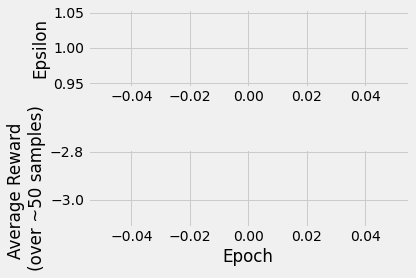

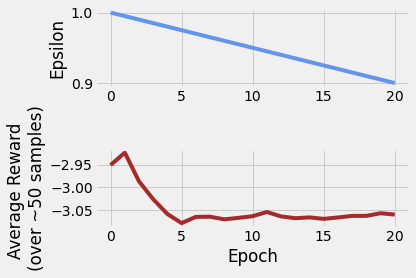

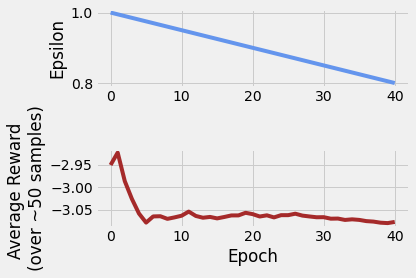

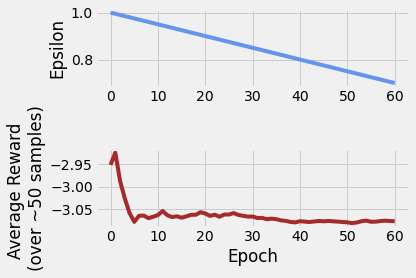

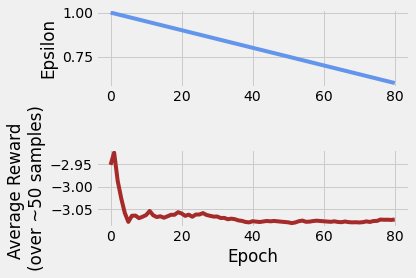

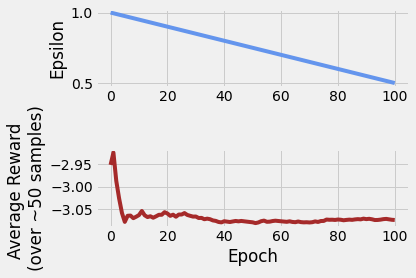

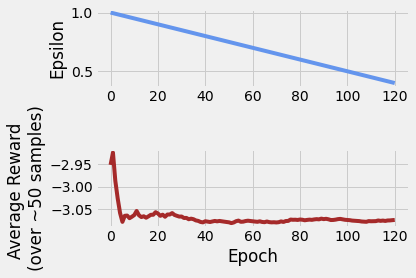

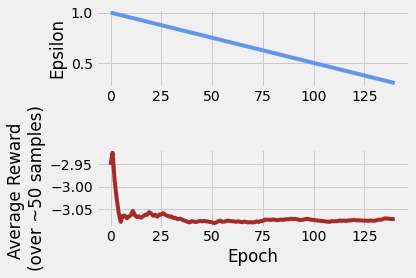

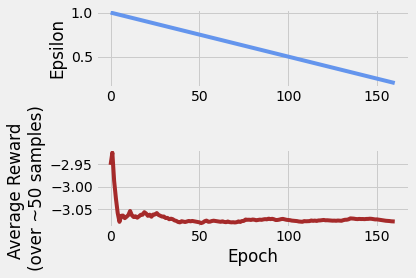

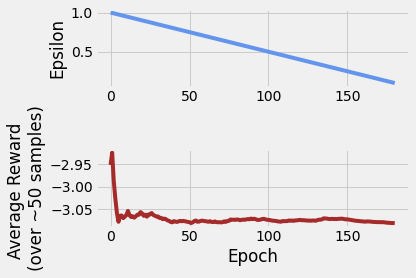

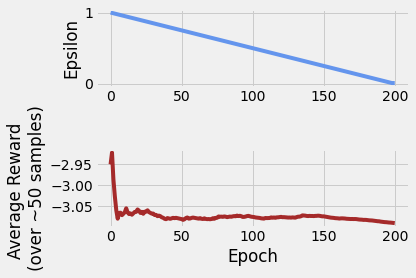

In [6]:
t = time()
config["training_dir"] = os.path.join(*['drive', 'My Drive', 'snakeAI', 'trainings', 'transfer_learningDQN', "ResNet50", datetime.now().strftime('%d%h%Y__%H%M%S%f')])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model = ResNet50(input_shape=IMAGE_SHAPE, num_not_trainable_blocks=NUM_NOT_TRAINABLE_BLOCKS)
model.build(input_shape=(None, *IMAGE_SHAPE))
model.compile(optimizer=optimizer)

model = train_dqn(model, optimizer, reward, **config)
t = time() - t

In [0]:
assert False
env = SnakeMaze(20, 20, 1, with_boundaries=False)
env.reset()
imgs = []
while env.num_active_agents:
    imgs.append(env.snake_matrices[0])
    # state = resize_image(env.snake_matrices[0], IMAGE_SIZE)
    direction = np.argmax(model(np.array([state])))
    env.step({0: direction})

In [0]:
generate_animation(imgs)